# Импорт либ

In [1]:
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
from torch import tensor
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

from PIL import Image

import numpy as np
from scipy import stats
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm 

import warnings

warnings.filterwarnings("ignore")

In [2]:
sns.set_theme()
pal = sns.set_palette([
    "#FF6347", "#4682B4", "#8A2BE2", "#FFD700", "#32CD32",
    "#FF4500", "#1E90FF", "#FF1493", "#00FA9A", "#FFDAB9",
    "#6A5ACD", "#FF8C00", "#ADFF2F", "#20B2AA", "#FF69B4",
    "#7B68EE", "#FFB6C1", "#00BFFF", "#F08080", "#DDA0DD"
])

# Гипер-параметры

In [3]:
BASE_DATA_DIR = '/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data' 
TRAIN_IMG_DIR = os.path.join(BASE_DATA_DIR, 'img_train')
TEST_IMG_DIR = os.path.join(BASE_DATA_DIR, 'img_test')
TRAIN_CSV_PATH = os.path.join(BASE_DATA_DIR, 'train_answers.csv')
CATEGORIES_CSV_PATH = os.path.join(BASE_DATA_DIR, 'activity_categories.csv')
SUBMISSION_CSV_PATH = 'submission.csv'
BEST_MODEL_PATH = 'best_model.pth'

BATCH_SIZE = 48
BATCH_SIZE_2 = 32
NUM_EPOCHS = 50
NUM_EPOCHS_2 = 100
LEARNING_RATE = 0.01

# Починка меток 

In [4]:
PRESENT_CLASS_IDS = [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, 18]
NUM_CLASSES = len(PRESENT_CLASS_IDS) 

# Создаем словарь для маппинга оригинальных ID в новые ID (0 до NUM_CLASSES-1)
original_to_dense_map = {original_id: dense_id for dense_id, original_id in enumerate(PRESENT_CLASS_IDS)}

# Создаем обратный словарь для маппинга новых ID обратно в оригинальные (понадобится для вывода)
dense_to_original_map = {dense_id: original_id for dense_id, original_id in enumerate(PRESENT_CLASS_IDS)}

categories_df = pd.read_csv(CATEGORIES_CSV_PATH)
categories_map = categories_df.set_index('id')['category'].to_dict()

## Базовый Dataset

* **path** - исходное месторасположение всех изображений;
* **transform** - преобразования, в частности **transforms.Compose**;
* **trainFlag** - флаг **train/test** *(True/False)*;
* **file_list** - список типа *(label : int, img_path : str)*.

In [5]:
class ImageDataset(Dataset):
    def __init__(self, path, transform):
        
        self.path = path
        self.transform = transform

    def __len__(self):
        
        return len(self.file_list)

    def __getitem__(self, idx):

        file_path = os.path.join(self.path, self.file_list[idx][1])

        with Image.open(file_path) as img:
            img = self.transform(img)
            return (img, self.file_list[idx][0])

## Transforms

### Аугментация **1.0**

In [ ]:
transform1 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=.54),
    transforms.RandomVerticalFlip(p=.34),
    transforms.RandomRotation([.0, 15]),
    transforms.RandomAutocontrast(.2),
    transforms.ColorJitter(
        brightness=.22,
        contrast=.22,
        saturation=[.28, .95],
        hue=[-.08, .08]
    ),
    transforms.ToTensor()
])

transformSimple = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.ToTensor()
])

### Аугментация **AntiHor**

In [ ]:
transform2 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=.54),
    transforms.RandomVerticalFlip(p=.34),
    transforms.RandomRotation([.0, 10]),
    transforms.RandomAutocontrast(.2),
    transforms.ColorJitter(
        brightness=.22,
        contrast=.22,
        saturation=[.28, .95],
        hue=[-.08, .08]
    ),
    transforms.ToTensor()
])

### Аугментация **Norm1.0**

In [ ]:
transform3 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=.54),
    transforms.RandomVerticalFlip(p=.34),
    transforms.RandomRotation([.0, 10]),
    transforms.RandomAutocontrast(.2),
    transforms.ColorJitter(
        brightness=.22,
        contrast=.22,
        saturation=[.28, .95],
        hue=[-.08, .08]
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

transformSimple2 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

### Аугментация **Norm2.0**

In [7]:
transform4 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=.54),
    transforms.RandomRotation([10, 20]),
    transforms.RandomAutocontrast(.2),
    transforms.ColorJitter(
        brightness=.22,
        contrast=.22,
        saturation=[.45, 1.5],
        hue=[-.1, .1]
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

### Аугментация **NormCorrected&PDF**

In [6]:
class CustomRandomRotation:
    def __init__(self, func, **kwrgs):
        
        self.function = {
            'normal' : np.random.normal,
            'chi2' : stats.chi2.rvs
        }[func]

        self.params = kwrgs

    def __call__(self, img):
        
        angle = self.function(**self.params)
        
        return transforms.functional.rotate(img, angle)

Суть в том, чтобы сделать акцент на величины с большей частотностью желаемого распределения, ниже представлен пример с **chi2** распредлением : в данном случае больший акцент на значениях промежутка **3-12**

<Axes: ylabel='Count'>

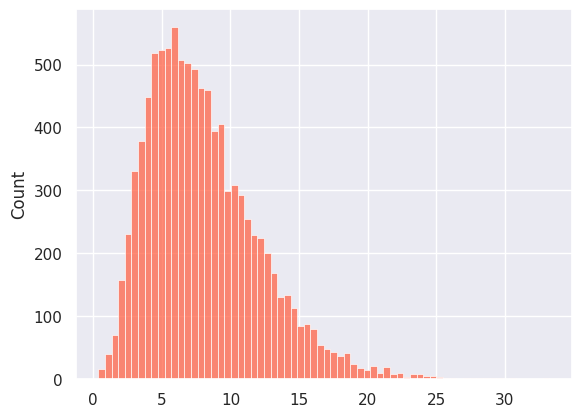

In [6]:
sns.histplot(x=stats.chi2.rvs(8, size=10000))

#### Вычисление **MEAN**, **STD**

In [ ]:
path = TRAIN_IMG_DIR

sum_pixels = torch.zeros((3,))
count = 0

sum_squares = torch.zeros((3,))

transform = transforms.Compose([transforms.ToTensor()])

for filename in os.listdir(path):
    img_path = os.path.join(path, filename)
    with Image.open(img_path) as img:
        img_tensor = transform(img)

        sum_pixels += img_tensor.mean(dim=(1, 2))
        count += 1

        sum_squares += (img_tensor ** 2).mean(dim=(1, 2))

mean = sum_pixels / count
std = (sum_squares / count - mean ** 2) ** 0.5

mean, std

In [7]:
transform5 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=.5),
    CustomRandomRotation('chi2', df=8),
    transforms.RandomAutocontrast(.2),
    transforms.ColorJitter(
        brightness=0,
        contrast=.2,
        saturation=[.45, 1.5],
        hue=[-.05, .05]
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=tensor([0.4674, 0.4497, 0.4122]), 
        std=tensor([0.2739, 0.2694, 0.2740])) # (tensor([0.4674, 0.4497, 0.4122]), tensor([0.2739, 0.2694, 0.2740]))
]) 

transformSimple3 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=tensor([0.4674, 0.4497, 0.4122]), 
        std=tensor([0.2739, 0.2694, 0.2740])) 
])

## Train-test-split

Идея в том, чтобы тосавать и разбивать **список путей к изображениям**, а после по ним уже получать соотв. данные

In [8]:
def train_test(path, path_answers, test_size=0.2, train_trans=None, test_trans=None, batch_size=64):

    file_list = os.listdir(path)
    answers_df = pd.read_csv(path_answers)

    target_dict = answers_df.set_index('img_id')['target_feature'].to_dict()

    objs = []
    for file in file_list:
        img_id = int(os.path.splitext(file)[0])
        target = target_dict.get(img_id)
        if target is not None and target in original_to_dense_map:
            dense_target = original_to_dense_map[target] 
            objs.append((dense_target, file)) 
            
    train_files, test_files = train_test_split(
    objs, test_size=test_size, random_state=42)

    train_dataset = ImageDataset(path, train_trans)
    train_dataset.file_list = train_files
    
    test_dataset = ImageDataset(path, test_trans)
    test_dataset.file_list = test_files
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True,  num_workers=6)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=6)

    return train_dataloader, test_dataloader

In [9]:
def plot_images(data_loader):
    first_batch = next(iter(data_loader))

    images = first_batch[0]
    labels = first_batch[1]

    fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(15, 5))

    classesByInLabels = pd.read_csv(CATEGORIES_CSV_PATH)

    for y in range(2):
        for x in range(6):
            axes[y, x].imshow(images[12 // (y + 1) - (x + 1)].permute(1, 2, 0))
            axes[y, x].set(xticks=[])
            axes[y, x].set(yticks=[])
            axes[y, x].set_title(classesByInLabels[classesByInLabels['id'] == int(labels[12 // (y + 1) - (x + 1)])]['category'].iloc[0])
            
    plt.plot()

In [ ]:
train_dataloader, test_dataloader = train_test(
    TRAIN_IMG_DIR, 
    TRAIN_CSV_PATH,
    train_trans=transform1,
    test_trans=transformSimple,
    batch_size=BATCH_SIZE)

In [ ]:
plot_images(train_dataloader) # тут слетели метки классов(

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Выбираем GPU для баффа к скорости
device

device(type='cuda')

# Модели

In [12]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip_connetcion = nn.Sequential()
        
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.skip_connetcion = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.skip_connetcion(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks):
        super(ResNet, self).__init__()
        
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, NUM_CLASSES)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, s))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

model = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)

## ResNet18

In [11]:
loss_function = nn.CrossEntropyLoss()

In [14]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### Summary

In [ ]:
summary(model, input_size=(3, 224, 224), device=device.type)

## Функции Тренеровки/Валидации

In [12]:
def train_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    total_samples = 0
    processed_batches = 0

    all_preds = []  
    all_labels = [] 

    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for batch in progress_bar:
        inputs, labels = batch  
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        processed_batches += 1

        all_preds.append(predicted.cpu())
        all_labels.append(labels.cpu())

        progress_bar.set_postfix(loss=f"{loss.item():.4f}")


    epoch_loss = running_loss / total_samples

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average='weighted', zero_division=0)

    return epoch_loss, f1 

def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_predictions = []
    total_samples = 0

    progress_bar = tqdm(dataloader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for batch in progress_bar:
            if batch is None or batch[0] is None or batch[1] is None:
                continue
            inputs, labels = batch 
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            total_samples += labels.size(0)


    epoch_loss = running_loss / total_samples
    f1 = f1_score(all_labels, all_predictions, average='macro', labels=list(range(NUM_CLASSES)), zero_division=0)


    return epoch_loss, f1

In [13]:
def train_model(model, device, train_dataloader, test_dataloader, optimizer, loss_function, scheduler, epochs) :
    print("Начало тренировки")
    history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []} 
    best_val_f1 = 0.0
    
    if train_dataloader is None or test_dataloader is None:
        print("Ошибка: DataLoader'ы не инициализированы.")
    else:
        for epoch in range(epochs):
            
            train_loss, train_f1 = train_epoch(model, train_dataloader, optimizer, loss_function, device)
    
            
            val_loss, val_f1 = evaluate(model, test_dataloader, loss_function, device)
    
    
            history['train_loss'].append(train_loss)
            history['train_f1'].append(train_f1)
            history['val_loss'].append(val_loss)
            history['val_f1'].append(val_f1)
    
    
            print(f"Эпоха {epoch+1}/{epochs}:")
            print(f"  Train Loss: {train_loss:.4f} | Train F1 (Macro): {train_f1:.4f}")
            print(f"  Val Loss:   {val_loss:.4f} | Val F1 (Macro): {val_f1:.4f}")
            print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}") 
    
    
            if scheduler:
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                     scheduler.step(val_f1)
                else:
                     scheduler.step() 
    
    
            if val_f1 > best_val_f1:
                print(f"  F1 улучшился ({best_val_f1:.4f} --> {val_f1:.4f}). Сохраняю модель в {BEST_MODEL_PATH}...")
                best_val_f1 = val_f1
                torch.save(model.state_dict(), BEST_MODEL_PATH)
    
    
        print("Тренеровка завершена!")
        print(f"Лучшая F1 (Macro) на валидации: {best_val_f1:.4f}")
    
    
        if os.path.exists(BEST_MODEL_PATH) and best_val_f1 > 0:
            print(f"Загружаю лучшую модель из {BEST_MODEL_PATH}")
            model.load_state_dict(torch.load(BEST_MODEL_PATH))
        else:
            print("Лучшая модель не сохранена(")

### Тренеровка 

In [ ]:
train_model(model, device, train_dataloader, test_dataloader, optimizer, loss_function, scheduler, NUM_EPOCHS)

### Отображение результатов

In [ ]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history['train_f1'], label='Train F1 (Macro)')
plt.title('F1')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history['val_f1'], label='Validation F1 (Macro)')
plt.title('F1')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## BottleNeck - новый блок?

Да, именно **BottleNeck** послужит ключевым инструментом нашей иной модели, причиной выдвинуть решение создания архитектурой с использованием **BottleNeck** стал следующий ряд преимуществ:
* **Количество параметров** - их меньше, поскольку изначально берется **Conv** с **kernel_size=1** вместо **kernel_size=3**, а также **kernel_size** применяется изначально с меньшим кол-во каналов, после уже передается в следующий, где происходит увеличение в зависимости от **expansion**-фактора;
* **Вычислительная сложность** - по сравнению с **BasicBlock** в среднем снижается в **10** раз;
* **Качество модели** - по статистике имеет **Score** не хуже/лучше при пред. преимуществах. 

In [17]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = torch.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        return torch.relu(out)


## CrocodiloNet - что это?

**CrocodiloNet** представляет из себя нейронку класса **ResNet**, однако его принципиальная разница от пред. моделей заключается в том, что вместо **BasicBlock** используется **BottleNeck**, что обеспечивает *экономию вычислительных процессов, временных ресурсов* путем *минимизации параметров* и позволяет нам создавать более *глубокие сети*

In [18]:
train_dataloader, test_dataloader = train_test(
    TRAIN_IMG_DIR, 
    TRAIN_CSV_PATH,
    train_trans=transform5,
    test_trans=transformSimple3,
    batch_size=48)

In [23]:
crocodiloModel = ResNet(Bottleneck, [2, 3, 4, 3]).to(device)

### Summary

In [18]:
summary(crocodiloModel, input_size=(3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
            Conv2d-7           [-1, 64, 56, 56]          36,864
       BatchNorm2d-8           [-1, 64, 56, 56]             128
            Conv2d-9          [-1, 256, 56, 56]          16,384
      BatchNorm2d-10          [-1, 256, 56, 56]             512
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
       Bottleneck-13          [-1, 256, 56, 56]               0
           Conv2d-14           [-1, 64,

In [24]:
optimizer2 = torch.optim.AdamW(crocodiloModel.parameters(), lr=0.01)
scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=7, gamma=0.5)

In [ ]:
train_model(crocodiloModel, device, train_dataloader, test_dataloader, optimizer2, loss_function, scheduler2, NUM_EPOCHS_2)

**Явное затухание**, что мы можем наблюдать вот уже близ **10-15-х** эпох. Предположительно, связано это с подобранным **LR=0.01** - **завышен**, также стоит опробовать **scheduler** c другими параметрами

In [26]:
crocodiloModel = ResNet(Bottleneck, [2, 3, 4, 3]).to(device)

In [27]:
optimizer3 = torch.optim.AdamW(
    crocodiloModel.parameters(), 
    lr=0.001,
    weight_decay=0.05
)

scheduler3 = torch.optim.lr_scheduler.SequentialLR(
    optimizer3,
    schedulers=[
        torch.optim.lr_scheduler.LinearLR(optimizer3, start_factor=0.33, total_iters=3),
        torch.optim.lr_scheduler.StepLR(optimizer3, step_size=7, gamma=0.5)
    ],
    milestones=[3]
)

In [ ]:
train_model(crocodiloModel, device, train_dataloader, test_dataloader, optimizer3, loss_function, scheduler3, 100)

### Дообучение

In [23]:
crocodiloModel.load_state_dict(torch.load('/kaggle/input/crocodilolast90/pytorch/default/1/last_model.pth', map_location=device))

<All keys matched successfully>

In [ ]:
train_model(crocodiloModel, device, train_dataloader, test_dataloader, optimizer3, loss_function, scheduler3, 60)

Начало тренировки


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 1/60:
  Train Loss: 0.2551 | Train F1 (Macro): 0.9134
  Val Loss:   1.6441 | Val F1 (Macro): 0.5871
  LR: 0.001000
  F1 улучшился (0.0000 --> 0.5871). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 2/60:
  Train Loss: 0.2269 | Train F1 (Macro): 0.9250
  Val Loss:   1.7161 | Val F1 (Macro): 0.5876
  LR: 0.001000
  F1 улучшился (0.5871 --> 0.5876). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 3/60:
  Train Loss: 0.2425 | Train F1 (Macro): 0.9180
  Val Loss:   1.8674 | Val F1 (Macro): 0.5689
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 4/60:
  Train Loss: 0.2298 | Train F1 (Macro): 0.9213
  Val Loss:   1.9845 | Val F1 (Macro): 0.5622
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 5/60:
  Train Loss: 0.2037 | Train F1 (Macro): 0.9317
  Val Loss:   1.7423 | Val F1 (Macro): 0.5773
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 6/60:
  Train Loss: 0.2017 | Train F1 (Macro): 0.9326
  Val Loss:   1.6815 | Val F1 (Macro): 0.5908
  LR: 0.001000
  F1 улучшился (0.5876 --> 0.5908). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 7/60:
  Train Loss: 0.2086 | Train F1 (Macro): 0.9286
  Val Loss:   1.8248 | Val F1 (Macro): 0.5708
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 8/60:
  Train Loss: 0.2512 | Train F1 (Macro): 0.9156
  Val Loss:   1.6437 | Val F1 (Macro): 0.5795
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 9/60:
  Train Loss: 0.2304 | Train F1 (Macro): 0.9261
  Val Loss:   1.6989 | Val F1 (Macro): 0.5907
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 10/60:
  Train Loss: 0.2328 | Train F1 (Macro): 0.9221
  Val Loss:   1.7547 | Val F1 (Macro): 0.5745
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 11/60:
  Train Loss: 0.1997 | Train F1 (Macro): 0.9362
  Val Loss:   1.6530 | Val F1 (Macro): 0.6028
  LR: 0.001000
  F1 улучшился (0.5908 --> 0.6028). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 12/60:
  Train Loss: 0.1851 | Train F1 (Macro): 0.9402
  Val Loss:   1.7214 | Val F1 (Macro): 0.5731
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 13/60:
  Train Loss: 0.1848 | Train F1 (Macro): 0.9384
  Val Loss:   1.9291 | Val F1 (Macro): 0.5816
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 14/60:
  Train Loss: 0.2258 | Train F1 (Macro): 0.9266
  Val Loss:   1.8911 | Val F1 (Macro): 0.5645
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 15/60:
  Train Loss: 0.2030 | Train F1 (Macro): 0.9356
  Val Loss:   1.6023 | Val F1 (Macro): 0.6150
  LR: 0.001000
  F1 улучшился (0.6028 --> 0.6150). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 16/60:
  Train Loss: 0.1538 | Train F1 (Macro): 0.9485
  Val Loss:   1.7794 | Val F1 (Macro): 0.5604
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 17/60:
  Train Loss: 0.1964 | Train F1 (Macro): 0.9350
  Val Loss:   1.7964 | Val F1 (Macro): 0.5871
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 18/60:
  Train Loss: 0.1940 | Train F1 (Macro): 0.9348
  Val Loss:   1.8863 | Val F1 (Macro): 0.5775
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 19/60:
  Train Loss: 0.2209 | Train F1 (Macro): 0.9264
  Val Loss:   1.7494 | Val F1 (Macro): 0.5952
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 20/60:
  Train Loss: 0.2206 | Train F1 (Macro): 0.9262
  Val Loss:   1.7442 | Val F1 (Macro): 0.5962
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 21/60:
  Train Loss: 0.1769 | Train F1 (Macro): 0.9405
  Val Loss:   1.6777 | Val F1 (Macro): 0.6026
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 22/60:
  Train Loss: 0.2055 | Train F1 (Macro): 0.9338
  Val Loss:   1.9120 | Val F1 (Macro): 0.5814
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

### Больше дообучения!

In [30]:
crocodiloModel.load_state_dict(torch.load('/kaggle/input/bestcrocodilo115/pytorch/default/1/bestmodel115.pth', map_location=device))

<All keys matched successfully>

In [31]:
train_model(crocodiloModel, device, train_dataloader, test_dataloader, optimizer3, loss_function, scheduler3, 15)

Начало тренировки


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 1/15:
  Train Loss: 0.0723 | Train F1 (Macro): 0.9792
  Val Loss:   1.5481 | Val F1 (Macro): 0.6362
  LR: 0.000330
  F1 улучшился (0.0000 --> 0.6362). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 2/15:
  Train Loss: 0.1067 | Train F1 (Macro): 0.9673
  Val Loss:   1.6268 | Val F1 (Macro): 0.6330
  LR: 0.000553


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 3/15:
  Train Loss: 0.1455 | Train F1 (Macro): 0.9500
  Val Loss:   1.8856 | Val F1 (Macro): 0.5842
  LR: 0.000777


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 4/15:
  Train Loss: 0.2685 | Train F1 (Macro): 0.9089
  Val Loss:   1.7920 | Val F1 (Macro): 0.5879
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 5/15:
  Train Loss: 0.2524 | Train F1 (Macro): 0.9157
  Val Loss:   1.7128 | Val F1 (Macro): 0.5905
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 6/15:
  Train Loss: 0.2222 | Train F1 (Macro): 0.9277
  Val Loss:   1.8449 | Val F1 (Macro): 0.5800
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 7/15:
  Train Loss: 0.1371 | Train F1 (Macro): 0.9579
  Val Loss:   1.6663 | Val F1 (Macro): 0.6019
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 8/15:
  Train Loss: 0.1833 | Train F1 (Macro): 0.9401
  Val Loss:   1.8180 | Val F1 (Macro): 0.5904
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 9/15:
  Train Loss: 0.1987 | Train F1 (Macro): 0.9351
  Val Loss:   1.8875 | Val F1 (Macro): 0.5800
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 10/15:
  Train Loss: 0.2394 | Train F1 (Macro): 0.9227
  Val Loss:   1.8549 | Val F1 (Macro): 0.5613
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 11/15:
  Train Loss: 0.0702 | Train F1 (Macro): 0.9788
  Val Loss:   1.5109 | Val F1 (Macro): 0.6421
  LR: 0.000500
  F1 улучшился (0.6362 --> 0.6421). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 12/15:
  Train Loss: 0.0464 | Train F1 (Macro): 0.9869
  Val Loss:   1.6324 | Val F1 (Macro): 0.6288
  LR: 0.000500


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 13/15:
  Train Loss: 0.0729 | Train F1 (Macro): 0.9773
  Val Loss:   1.5609 | Val F1 (Macro): 0.6384
  LR: 0.000500


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 14/15:
  Train Loss: 0.0599 | Train F1 (Macro): 0.9816
  Val Loss:   1.5319 | Val F1 (Macro): 0.6398
  LR: 0.000500


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 15/15:
  Train Loss: 0.0614 | Train F1 (Macro): 0.9824
  Val Loss:   1.6135 | Val F1 (Macro): 0.6387
  LR: 0.000500
Тренеровка завершена!
Лучшая F1 (Macro) на валидации: 0.6421
Загружаю лучшую модель из best_model.pth


In [32]:
train_model(crocodiloModel, device, train_dataloader, test_dataloader, optimizer3, loss_function, scheduler3, 10)

Начало тренировки


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 1/10:
  Train Loss: 0.0607 | Train F1 (Macro): 0.9811
  Val Loss:   1.5466 | Val F1 (Macro): 0.6514
  LR: 0.000500
  F1 улучшился (0.0000 --> 0.6514). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 2/10:
  Train Loss: 0.0460 | Train F1 (Macro): 0.9859
  Val Loss:   1.6841 | Val F1 (Macro): 0.6259
  LR: 0.000500


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 3/10:
  Train Loss: 0.0471 | Train F1 (Macro): 0.9862
  Val Loss:   1.5973 | Val F1 (Macro): 0.6534
  LR: 0.000250
  F1 улучшился (0.6514 --> 0.6534). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 4/10:
  Train Loss: 0.0368 | Train F1 (Macro): 0.9902
  Val Loss:   1.5400 | Val F1 (Macro): 0.6581
  LR: 0.000250
  F1 улучшился (0.6534 --> 0.6581). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 5/10:
  Train Loss: 0.0268 | Train F1 (Macro): 0.9928
  Val Loss:   1.5622 | Val F1 (Macro): 0.6508
  LR: 0.000250


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 6/10:
  Train Loss: 0.0201 | Train F1 (Macro): 0.9948
  Val Loss:   1.5892 | Val F1 (Macro): 0.6599
  LR: 0.000250
  F1 улучшился (0.6581 --> 0.6599). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 7/10:
  Train Loss: 0.0235 | Train F1 (Macro): 0.9930
  Val Loss:   1.5915 | Val F1 (Macro): 0.6528
  LR: 0.000250


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 8/10:
  Train Loss: 0.0339 | Train F1 (Macro): 0.9903
  Val Loss:   1.6849 | Val F1 (Macro): 0.6439
  LR: 0.000250


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 9/10:
  Train Loss: 0.0332 | Train F1 (Macro): 0.9912
  Val Loss:   1.6579 | Val F1 (Macro): 0.6402
  LR: 0.000250


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 10/10:
  Train Loss: 0.0253 | Train F1 (Macro): 0.9931
  Val Loss:   1.6126 | Val F1 (Macro): 0.6500
  LR: 0.000125
Тренеровка завершена!
Лучшая F1 (Macro) на валидации: 0.6599
Загружаю лучшую модель из best_model.pth


Как мы можем увидеть по последним показателям, тенденция стремления **F1-score** примерно, предположительно, к **0.66-0.67** на **Validation**-выборке (выслали)

## MobileNetV2

In [14]:
class MobBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, expansion, stride=1):
        super(MobBottleneck, self).__init__()
        hidden_dim = in_channels * expansion

        self.mainConvolution = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            
            nn.Conv2d(hidden_dim, hidden_dim, 
                     kernel_size=3, stride=stride, 
                     padding=1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.shortcut = nn.Sequential()
        if stride == 1 and in_channels == out_channels:
            self.shortcut = nn.Identity()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 
                         kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        return self.mainConvolution(x) + self.shortcut(x)

class MobileNetV2(nn.Module):
    def __init__(self, block, num_blocks):
        super(MobileNetV2, self).__init__()
        
        self.in_channels = 32
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU6(inplace=True)
        
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1, expansion=1)
        self.layer2 = self._make_layer(block, 24, num_blocks[1], stride=2, expansion=6)
        self.layer3 = self._make_layer(block, 32, num_blocks[2], stride=2, expansion=6)
        self.layer4 = self._make_layer(block, 64, num_blocks[3], stride=2, expansion=6)
        self.layer5 = self._make_layer(block, 96, num_blocks[4], stride=1, expansion=6)
        self.layer6 = self._make_layer(block, 160, num_blocks[5], stride=2, expansion=6)
        self.layer7 = self._make_layer(block, 320, num_blocks[6], stride=1, expansion=6)
        
        self.conv2 = nn.Conv2d(320, 1280, kernel_size=1, bias=False)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1280, NUM_CLASSES)

    def _make_layer(self, block, out_channels, num_blocks, stride, expansion):
        
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(
                self.in_channels, 
                out_channels,
                stride=stride,
                expansion=expansion
            ))
            self.in_channels = out_channels
            
        return nn.Sequential(*layers)

    def forward(self, x):
        
        x = self.relu(self.bn1(self.conv1(x)))
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        
        x = self.relu(self.conv2(x))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        self.dropout = nn.Dropout(p=0.2)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x


## MobileTralalelo

In [15]:
train_dataloader, test_dataloader = train_test(
    TRAIN_IMG_DIR, 
    TRAIN_CSV_PATH,
    train_trans=transform5,
    test_trans=transformSimple3,
    batch_size=64)

In [16]:
MobileTralalelo = MobileNetV2(MobBottleneck, [1, 2, 3, 4, 3, 3, 1]).to(device)

### Summary 

In [37]:
summary(MobileTralalelo, input_size=(3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           1,024
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 32, 112, 112]             288
       BatchNorm2d-8         [-1, 32, 112, 112]              64
             ReLU6-9         [-1, 32, 112, 112]               0
           Conv2d-10         [-1, 16, 112, 112]             512
      BatchNorm2d-11         [-1, 16, 112, 112]              32
           Conv2d-12         [-1, 16, 112, 112]             512
      BatchNorm2d-13         [-1, 16, 112, 112]              32
    MobBottleneck-14         [-1, 16, 1

In [17]:
optimizer4 = torch.optim.AdamW(MobileTralalelo.parameters(), 
    lr=0.001, 
    weight_decay=1e-4,
    betas=(0.9, 0.999), 
    eps=1e-8)

scheduler4 = torch.optim.lr_scheduler.OneCycleLR(
    optimizer4,
    max_lr=3e-3,        
    total_steps=200*187,
    pct_start=0.15,     
    anneal_strategy='cos'
)

### Тренеровка

In [32]:
train_model(MobileTralalelo, device, train_dataloader, test_dataloader, optimizer4, loss_function, scheduler4, 25)

Начало тренировки


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 1/25:
  Train Loss: 2.3888 | Train F1 (Macro): 0.1620
  Val Loss:   2.2020 | Val F1 (Macro): 0.1564
  LR: 0.000120
  F1 улучшился (0.0000 --> 0.1564). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 2/25:
  Train Loss: 2.2121 | Train F1 (Macro): 0.2366
  Val Loss:   2.0946 | Val F1 (Macro): 0.2043
  LR: 0.000120
  F1 улучшился (0.1564 --> 0.2043). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 3/25:
  Train Loss: 2.1237 | Train F1 (Macro): 0.2675
  Val Loss:   2.0750 | Val F1 (Macro): 0.2148
  LR: 0.000120
  F1 улучшился (0.2043 --> 0.2148). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 4/25:
  Train Loss: 2.0716 | Train F1 (Macro): 0.2819
  Val Loss:   1.9933 | Val F1 (Macro): 0.2358
  LR: 0.000120
  F1 улучшился (0.2148 --> 0.2358). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 5/25:
  Train Loss: 2.0227 | Train F1 (Macro): 0.3023
  Val Loss:   1.9408 | Val F1 (Macro): 0.2564
  LR: 0.000120
  F1 улучшился (0.2358 --> 0.2564). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 6/25:
  Train Loss: 1.9800 | Train F1 (Macro): 0.3155
  Val Loss:   1.9299 | Val F1 (Macro): 0.2759
  LR: 0.000120
  F1 улучшился (0.2564 --> 0.2759). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 7/25:
  Train Loss: 1.9280 | Train F1 (Macro): 0.3360
  Val Loss:   1.8960 | Val F1 (Macro): 0.2695
  LR: 0.000120


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 8/25:
  Train Loss: 1.8992 | Train F1 (Macro): 0.3484
  Val Loss:   1.8682 | Val F1 (Macro): 0.2890
  LR: 0.000120
  F1 улучшился (0.2759 --> 0.2890). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 9/25:
  Train Loss: 1.8461 | Train F1 (Macro): 0.3672
  Val Loss:   1.8018 | Val F1 (Macro): 0.2986
  LR: 0.000120
  F1 улучшился (0.2890 --> 0.2986). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 10/25:
  Train Loss: 1.7944 | Train F1 (Macro): 0.3899
  Val Loss:   1.8193 | Val F1 (Macro): 0.3142
  LR: 0.000120
  F1 улучшился (0.2986 --> 0.3142). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 11/25:
  Train Loss: 1.7619 | Train F1 (Macro): 0.3967
  Val Loss:   1.7565 | Val F1 (Macro): 0.3438
  LR: 0.000120
  F1 улучшился (0.3142 --> 0.3438). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 12/25:
  Train Loss: 1.7150 | Train F1 (Macro): 0.4121
  Val Loss:   1.7179 | Val F1 (Macro): 0.3690
  LR: 0.000120
  F1 улучшился (0.3438 --> 0.3690). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 13/25:
  Train Loss: 1.6904 | Train F1 (Macro): 0.4274
  Val Loss:   1.6978 | Val F1 (Macro): 0.3743
  LR: 0.000120
  F1 улучшился (0.3690 --> 0.3743). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 14/25:
  Train Loss: 1.6324 | Train F1 (Macro): 0.4464
  Val Loss:   1.6514 | Val F1 (Macro): 0.3757
  LR: 0.000120
  F1 улучшился (0.3743 --> 0.3757). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 15/25:
  Train Loss: 1.5915 | Train F1 (Macro): 0.4566
  Val Loss:   1.6779 | Val F1 (Macro): 0.3739
  LR: 0.000120


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 16/25:
  Train Loss: 1.5568 | Train F1 (Macro): 0.4752
  Val Loss:   1.6439 | Val F1 (Macro): 0.3922
  LR: 0.000120
  F1 улучшился (0.3757 --> 0.3922). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 17/25:
  Train Loss: 1.5108 | Train F1 (Macro): 0.4843
  Val Loss:   1.6085 | Val F1 (Macro): 0.4030
  LR: 0.000120
  F1 улучшился (0.3922 --> 0.4030). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 18/25:
  Train Loss: 1.4620 | Train F1 (Macro): 0.5032
  Val Loss:   1.5961 | Val F1 (Macro): 0.4181
  LR: 0.000120
  F1 улучшился (0.4030 --> 0.4181). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 19/25:
  Train Loss: 1.4175 | Train F1 (Macro): 0.5233
  Val Loss:   1.5993 | Val F1 (Macro): 0.4286
  LR: 0.000120
  F1 улучшился (0.4181 --> 0.4286). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 20/25:
  Train Loss: 1.3969 | Train F1 (Macro): 0.5315
  Val Loss:   1.5384 | Val F1 (Macro): 0.4379
  LR: 0.000120
  F1 улучшился (0.4286 --> 0.4379). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 21/25:
  Train Loss: 1.3150 | Train F1 (Macro): 0.5607
  Val Loss:   1.5035 | Val F1 (Macro): 0.4608
  LR: 0.000120
  F1 улучшился (0.4379 --> 0.4608). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 22/25:
  Train Loss: 1.3005 | Train F1 (Macro): 0.5610
  Val Loss:   1.4980 | Val F1 (Macro): 0.4400
  LR: 0.000120


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 23/25:
  Train Loss: 1.2499 | Train F1 (Macro): 0.5850
  Val Loss:   1.5237 | Val F1 (Macro): 0.4685
  LR: 0.000120
  F1 улучшился (0.4608 --> 0.4685). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 24/25:
  Train Loss: 1.2008 | Train F1 (Macro): 0.6001
  Val Loss:   1.5295 | Val F1 (Macro): 0.4711
  LR: 0.000120
  F1 улучшился (0.4685 --> 0.4711). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 25/25:
  Train Loss: 1.1713 | Train F1 (Macro): 0.6125
  Val Loss:   1.4500 | Val F1 (Macro): 0.4960
  LR: 0.000120
  F1 улучшился (0.4711 --> 0.4960). Сохраняю модель в best_model.pth...
Тренеровка завершена!
Лучшая F1 (Macro) на валидации: 0.4960
Загружаю лучшую модель из best_model.pth


Как мы видим, на первых **25** эпохах наша модель показывает **F1=0.496**, что ближе к хорошему результату при имеющихся оптимизаторе и **scheduler** 

### Загрузка и дальнейшее обучение

In [33]:
torch.save({
    'model': MobileTralalelo.state_dict(),
    'optimizer': optimizer4.state_dict(),
    'scheduler': scheduler4.state_dict(),
}, 'TralaleloPoint.pth')

In [24]:
checkpoint = torch.load('/kaggle/input/tralalelotrue25/pytorch/default/1/TralaleloPoint.pth')

MobileTralalelo.load_state_dict(checkpoint['model'])
optimizer4.load_state_dict(checkpoint['optimizer'])
scheduler4.load_state_dict(checkpoint['scheduler'])

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/tralalelotrue25/pytorch/default/1/TralaleloPoint2.pth'

In [23]:
train_model(MobileTralalelo, device, train_dataloader, test_dataloader, optimizer4, loss_function, scheduler4, 50)

Начало тренировки


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 1/50:
  Train Loss: 1.0677 | Train F1 (Macro): 0.6462
  Val Loss:   1.4581 | Val F1 (Macro): 0.4817
  LR: 0.000120
  F1 улучшился (0.0000 --> 0.4817). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 2/50:
  Train Loss: 1.0204 | Train F1 (Macro): 0.6611
  Val Loss:   1.4194 | Val F1 (Macro): 0.5011
  LR: 0.000120
  F1 улучшился (0.4817 --> 0.5011). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 3/50:
  Train Loss: 0.9883 | Train F1 (Macro): 0.6774
  Val Loss:   1.4921 | Val F1 (Macro): 0.4894
  LR: 0.000120


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 4/50:
  Train Loss: 0.9593 | Train F1 (Macro): 0.6783
  Val Loss:   1.4444 | Val F1 (Macro): 0.4897
  LR: 0.000120


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 5/50:
  Train Loss: 0.8966 | Train F1 (Macro): 0.7031
  Val Loss:   1.4058 | Val F1 (Macro): 0.5163
  LR: 0.000120
  F1 улучшился (0.5011 --> 0.5163). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 6/50:
  Train Loss: 0.8774 | Train F1 (Macro): 0.7068
  Val Loss:   1.5003 | Val F1 (Macro): 0.4921
  LR: 0.000120


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 7/50:
  Train Loss: 0.8418 | Train F1 (Macro): 0.7207
  Val Loss:   1.4574 | Val F1 (Macro): 0.5059
  LR: 0.000120


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 8/50:
  Train Loss: 0.8108 | Train F1 (Macro): 0.7301
  Val Loss:   1.4656 | Val F1 (Macro): 0.5187
  LR: 0.000120
  F1 улучшился (0.5163 --> 0.5187). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 9/50:
  Train Loss: 0.7846 | Train F1 (Macro): 0.7360
  Val Loss:   1.5024 | Val F1 (Macro): 0.5049
  LR: 0.000120


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 10/50:
  Train Loss: 0.7585 | Train F1 (Macro): 0.7498
  Val Loss:   1.4478 | Val F1 (Macro): 0.5338
  LR: 0.000120
  F1 улучшился (0.5187 --> 0.5338). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 11/50:
  Train Loss: 0.7148 | Train F1 (Macro): 0.7672
  Val Loss:   1.4476 | Val F1 (Macro): 0.5469
  LR: 0.000120
  F1 улучшился (0.5338 --> 0.5469). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 12/50:
  Train Loss: 0.6888 | Train F1 (Macro): 0.7706
  Val Loss:   1.4408 | Val F1 (Macro): 0.5415
  LR: 0.000120


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 13/50:
  Train Loss: 0.6597 | Train F1 (Macro): 0.7777
  Val Loss:   1.5340 | Val F1 (Macro): 0.5187
  LR: 0.000120


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 14/50:
  Train Loss: 0.6138 | Train F1 (Macro): 0.7989
  Val Loss:   1.4626 | Val F1 (Macro): 0.5482
  LR: 0.000120
  F1 улучшился (0.5469 --> 0.5482). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 15/50:
  Train Loss: 0.6039 | Train F1 (Macro): 0.8007
  Val Loss:   1.4866 | Val F1 (Macro): 0.5446
  LR: 0.000120


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 16/50:
  Train Loss: 0.5857 | Train F1 (Macro): 0.8035
  Val Loss:   1.4938 | Val F1 (Macro): 0.5643
  LR: 0.000120
  F1 улучшился (0.5482 --> 0.5643). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 17/50:
  Train Loss: 0.5557 | Train F1 (Macro): 0.8172
  Val Loss:   1.5226 | Val F1 (Macro): 0.5471
  LR: 0.000120


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 18/50:
  Train Loss: 0.5221 | Train F1 (Macro): 0.8287
  Val Loss:   1.5523 | Val F1 (Macro): 0.5399
  LR: 0.000120


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 19/50:
  Train Loss: 0.5044 | Train F1 (Macro): 0.8301
  Val Loss:   1.5006 | Val F1 (Macro): 0.5505
  LR: 0.000120


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 20/50:
  Train Loss: 0.4779 | Train F1 (Macro): 0.8410
  Val Loss:   1.5226 | Val F1 (Macro): 0.5573
  LR: 0.000120


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 21/50:
  Train Loss: 0.4688 | Train F1 (Macro): 0.8445
  Val Loss:   1.5598 | Val F1 (Macro): 0.5506
  LR: 0.000120


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 22/50:
  Train Loss: 0.4624 | Train F1 (Macro): 0.8436
  Val Loss:   1.5574 | Val F1 (Macro): 0.5552
  LR: 0.000120


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 23/50:
  Train Loss: 0.4320 | Train F1 (Macro): 0.8558
  Val Loss:   1.5788 | Val F1 (Macro): 0.5524
  LR: 0.000120


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 24/50:
  Train Loss: 0.4183 | Train F1 (Macro): 0.8588
  Val Loss:   1.5550 | Val F1 (Macro): 0.5687
  LR: 0.000121
  F1 улучшился (0.5643 --> 0.5687). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 25/50:
  Train Loss: 0.3766 | Train F1 (Macro): 0.8739
  Val Loss:   1.6498 | Val F1 (Macro): 0.5581
  LR: 0.000121


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 26/50:
  Train Loss: 0.3857 | Train F1 (Macro): 0.8694
  Val Loss:   1.5849 | Val F1 (Macro): 0.5589
  LR: 0.000121


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 27/50:
  Train Loss: 0.3597 | Train F1 (Macro): 0.8776
  Val Loss:   1.6735 | Val F1 (Macro): 0.5647
  LR: 0.000121


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 28/50:
  Train Loss: 0.3530 | Train F1 (Macro): 0.8809
  Val Loss:   1.7048 | Val F1 (Macro): 0.5619
  LR: 0.000121


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 29/50:
  Train Loss: 0.3455 | Train F1 (Macro): 0.8837
  Val Loss:   1.6508 | Val F1 (Macro): 0.5658
  LR: 0.000121


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 30/50:
  Train Loss: 0.3267 | Train F1 (Macro): 0.8915
  Val Loss:   1.6432 | Val F1 (Macro): 0.5716
  LR: 0.000121
  F1 улучшился (0.5687 --> 0.5716). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 31/50:
  Train Loss: 0.3149 | Train F1 (Macro): 0.8964
  Val Loss:   1.6777 | Val F1 (Macro): 0.5633
  LR: 0.000121


Training:   0%|          | 0/155 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [25]:
torch.save({
    'model': MobileTralalelo.state_dict(),
    'optimizer': optimizer4.state_dict(),
    'scheduler': scheduler4.state_dict(),
}, 'TralaleloPoint.pth')

In [18]:
checkpoint = torch.load('/kaggle/input/tralalelotrue55/pytorch/default/1/TralaleloPoint (1).pth')

MobileTralalelo.load_state_dict(checkpoint['model'])
optimizer4.load_state_dict(checkpoint['optimizer'])
scheduler4.load_state_dict(checkpoint['scheduler'])

In [19]:
train_model(MobileTralalelo, device, train_dataloader, test_dataloader, optimizer4, loss_function, scheduler4, 30)

Начало тренировки


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 1/30:
  Train Loss: 0.3165 | Train F1 (Macro): 0.8903
  Val Loss:   1.7192 | Val F1 (Macro): 0.5805
  LR: 0.000121
  F1 улучшился (0.0000 --> 0.5805). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 2/30:
  Train Loss: 0.2939 | Train F1 (Macro): 0.9007
  Val Loss:   1.7254 | Val F1 (Macro): 0.5621
  LR: 0.000121


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 3/30:
  Train Loss: 0.2871 | Train F1 (Macro): 0.9038
  Val Loss:   1.6450 | Val F1 (Macro): 0.5790
  LR: 0.000121


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 4/30:
  Train Loss: 0.2790 | Train F1 (Macro): 0.9070
  Val Loss:   1.7172 | Val F1 (Macro): 0.5736
  LR: 0.000121


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 5/30:
  Train Loss: 0.2638 | Train F1 (Macro): 0.9103
  Val Loss:   1.7614 | Val F1 (Macro): 0.5729
  LR: 0.000121


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 6/30:
  Train Loss: 0.2463 | Train F1 (Macro): 0.9161
  Val Loss:   1.7203 | Val F1 (Macro): 0.5737
  LR: 0.000121


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 7/30:
  Train Loss: 0.2491 | Train F1 (Macro): 0.9156
  Val Loss:   1.7881 | Val F1 (Macro): 0.5737
  LR: 0.000121


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 8/30:
  Train Loss: 0.2579 | Train F1 (Macro): 0.9129
  Val Loss:   1.7714 | Val F1 (Macro): 0.5690
  LR: 0.000121


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 9/30:
  Train Loss: 0.2410 | Train F1 (Macro): 0.9182
  Val Loss:   1.7981 | Val F1 (Macro): 0.5608
  LR: 0.000121


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 10/30:
  Train Loss: 0.2311 | Train F1 (Macro): 0.9228
  Val Loss:   1.7860 | Val F1 (Macro): 0.5763
  LR: 0.000121


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 11/30:
  Train Loss: 0.2507 | Train F1 (Macro): 0.9169
  Val Loss:   1.8018 | Val F1 (Macro): 0.5748
  LR: 0.000121


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 12/30:
  Train Loss: 0.2365 | Train F1 (Macro): 0.9202
  Val Loss:   1.7724 | Val F1 (Macro): 0.5811
  LR: 0.000121
  F1 улучшился (0.5805 --> 0.5811). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 13/30:
  Train Loss: 0.2139 | Train F1 (Macro): 0.9299
  Val Loss:   1.7707 | Val F1 (Macro): 0.5770
  LR: 0.000121


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 14/30:
  Train Loss: 0.2075 | Train F1 (Macro): 0.9291
  Val Loss:   1.8156 | Val F1 (Macro): 0.5741
  LR: 0.000121


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 15/30:
  Train Loss: 0.2244 | Train F1 (Macro): 0.9254
  Val Loss:   1.8986 | Val F1 (Macro): 0.5481
  LR: 0.000121


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 16/30:
  Train Loss: 0.2271 | Train F1 (Macro): 0.9220
  Val Loss:   1.8915 | Val F1 (Macro): 0.5745
  LR: 0.000121


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 17/30:
  Train Loss: 0.1797 | Train F1 (Macro): 0.9432
  Val Loss:   1.8405 | Val F1 (Macro): 0.5725
  LR: 0.000121


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 18/30:
  Train Loss: 0.1930 | Train F1 (Macro): 0.9340
  Val Loss:   1.8898 | Val F1 (Macro): 0.5615
  LR: 0.000121


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 19/30:
  Train Loss: 0.1819 | Train F1 (Macro): 0.9385
  Val Loss:   1.9250 | Val F1 (Macro): 0.5727
  LR: 0.000121


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 20/30:
  Train Loss: 0.1873 | Train F1 (Macro): 0.9412
  Val Loss:   1.9222 | Val F1 (Macro): 0.5609
  LR: 0.000121


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 21/30:
  Train Loss: 0.1960 | Train F1 (Macro): 0.9364
  Val Loss:   1.8710 | Val F1 (Macro): 0.5923
  LR: 0.000121
  F1 улучшился (0.5811 --> 0.5923). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 22/30:
  Train Loss: 0.1939 | Train F1 (Macro): 0.9328
  Val Loss:   1.7929 | Val F1 (Macro): 0.5837
  LR: 0.000121


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 23/30:
  Train Loss: 0.1947 | Train F1 (Macro): 0.9359
  Val Loss:   1.8256 | Val F1 (Macro): 0.5946
  LR: 0.000121
  F1 улучшился (0.5923 --> 0.5946). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 24/30:
  Train Loss: 0.1788 | Train F1 (Macro): 0.9400
  Val Loss:   1.9043 | Val F1 (Macro): 0.5918
  LR: 0.000121


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 25/30:
  Train Loss: 0.1588 | Train F1 (Macro): 0.9469
  Val Loss:   1.8884 | Val F1 (Macro): 0.5959
  LR: 0.000121
  F1 улучшился (0.5946 --> 0.5959). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 26/30:
  Train Loss: 0.1763 | Train F1 (Macro): 0.9436
  Val Loss:   1.9056 | Val F1 (Macro): 0.5831
  LR: 0.000121


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 27/30:
  Train Loss: 0.1618 | Train F1 (Macro): 0.9444
  Val Loss:   1.9649 | Val F1 (Macro): 0.5720
  LR: 0.000122


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 28/30:
  Train Loss: 0.1733 | Train F1 (Macro): 0.9444
  Val Loss:   1.9227 | Val F1 (Macro): 0.5833
  LR: 0.000122


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 29/30:
  Train Loss: 0.1825 | Train F1 (Macro): 0.9359
  Val Loss:   1.9465 | Val F1 (Macro): 0.5818
  LR: 0.000122


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 30/30:
  Train Loss: 0.1502 | Train F1 (Macro): 0.9493
  Val Loss:   1.8788 | Val F1 (Macro): 0.5941
  LR: 0.000122
Тренеровка завершена!
Лучшая F1 (Macro) на валидации: 0.5959
Загружаю лучшую модель из best_model.pth


In [21]:
train_model(MobileTralalelo, device, train_dataloader, test_dataloader, optimizer4, loss_function, scheduler4, 45)

Начало тренировки


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 1/45:
  Train Loss: 0.1581 | Train F1 (Macro): 0.9468
  Val Loss:   1.8913 | Val F1 (Macro): 0.5921
  LR: 0.000122
  F1 улучшился (0.0000 --> 0.5921). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 2/45:
  Train Loss: 0.1654 | Train F1 (Macro): 0.9447
  Val Loss:   1.8673 | Val F1 (Macro): 0.5878
  LR: 0.000122


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 3/45:
  Train Loss: 0.1643 | Train F1 (Macro): 0.9453
  Val Loss:   1.9172 | Val F1 (Macro): 0.5860
  LR: 0.000122


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 4/45:
  Train Loss: 0.1613 | Train F1 (Macro): 0.9475
  Val Loss:   1.9017 | Val F1 (Macro): 0.5825
  LR: 0.000122


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 5/45:
  Train Loss: 0.1667 | Train F1 (Macro): 0.9439
  Val Loss:   1.9463 | Val F1 (Macro): 0.5786
  LR: 0.000122


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 6/45:
  Train Loss: 0.1644 | Train F1 (Macro): 0.9453
  Val Loss:   1.9087 | Val F1 (Macro): 0.5926
  LR: 0.000122
  F1 улучшился (0.5921 --> 0.5926). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 7/45:
  Train Loss: 0.1591 | Train F1 (Macro): 0.9447
  Val Loss:   1.9461 | Val F1 (Macro): 0.5935
  LR: 0.000122
  F1 улучшился (0.5926 --> 0.5935). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 8/45:
  Train Loss: 0.1618 | Train F1 (Macro): 0.9461
  Val Loss:   1.9148 | Val F1 (Macro): 0.5918
  LR: 0.000122


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 9/45:
  Train Loss: 0.1478 | Train F1 (Macro): 0.9512
  Val Loss:   1.9741 | Val F1 (Macro): 0.5929
  LR: 0.000122


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 10/45:
  Train Loss: 0.1503 | Train F1 (Macro): 0.9507
  Val Loss:   1.9142 | Val F1 (Macro): 0.5945
  LR: 0.000122
  F1 улучшился (0.5935 --> 0.5945). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 11/45:
  Train Loss: 0.1322 | Train F1 (Macro): 0.9539
  Val Loss:   1.9939 | Val F1 (Macro): 0.5871
  LR: 0.000122


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 12/45:
  Train Loss: 0.1389 | Train F1 (Macro): 0.9531
  Val Loss:   1.9631 | Val F1 (Macro): 0.5879
  LR: 0.000122


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 13/45:
  Train Loss: 0.1519 | Train F1 (Macro): 0.9480
  Val Loss:   1.9701 | Val F1 (Macro): 0.5983
  LR: 0.000122
  F1 улучшился (0.5945 --> 0.5983). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 14/45:
  Train Loss: 0.1374 | Train F1 (Macro): 0.9554
  Val Loss:   2.0173 | Val F1 (Macro): 0.5882
  LR: 0.000122


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 15/45:
  Train Loss: 0.1447 | Train F1 (Macro): 0.9503
  Val Loss:   1.9283 | Val F1 (Macro): 0.6076
  LR: 0.000122
  F1 улучшился (0.5983 --> 0.6076). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 16/45:
  Train Loss: 0.1416 | Train F1 (Macro): 0.9491
  Val Loss:   2.0497 | Val F1 (Macro): 0.5870
  LR: 0.000122


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 17/45:
  Train Loss: 0.1354 | Train F1 (Macro): 0.9561
  Val Loss:   2.0059 | Val F1 (Macro): 0.5816
  LR: 0.000122


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 18/45:
  Train Loss: 0.1241 | Train F1 (Macro): 0.9592
  Val Loss:   2.0244 | Val F1 (Macro): 0.5786
  LR: 0.000122


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 19/45:
  Train Loss: 0.1469 | Train F1 (Macro): 0.9533
  Val Loss:   1.9780 | Val F1 (Macro): 0.5950
  LR: 0.000122


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 20/45:
  Train Loss: 0.1462 | Train F1 (Macro): 0.9520
  Val Loss:   2.0315 | Val F1 (Macro): 0.5865
  LR: 0.000122


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 21/45:
  Train Loss: 0.1299 | Train F1 (Macro): 0.9556
  Val Loss:   1.9048 | Val F1 (Macro): 0.5941
  LR: 0.000123


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 22/45:
  Train Loss: 0.1311 | Train F1 (Macro): 0.9558
  Val Loss:   1.9722 | Val F1 (Macro): 0.5890
  LR: 0.000123


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 23/45:
  Train Loss: 0.1130 | Train F1 (Macro): 0.9606
  Val Loss:   1.9962 | Val F1 (Macro): 0.5833
  LR: 0.000123


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 24/45:
  Train Loss: 0.1200 | Train F1 (Macro): 0.9602
  Val Loss:   2.1060 | Val F1 (Macro): 0.5759
  LR: 0.000123


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 25/45:
  Train Loss: 0.1314 | Train F1 (Macro): 0.9554
  Val Loss:   2.1166 | Val F1 (Macro): 0.5785
  LR: 0.000123


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 26/45:
  Train Loss: 0.1426 | Train F1 (Macro): 0.9525
  Val Loss:   2.0747 | Val F1 (Macro): 0.5884
  LR: 0.000123


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 27/45:
  Train Loss: 0.1206 | Train F1 (Macro): 0.9600
  Val Loss:   2.0831 | Val F1 (Macro): 0.5929
  LR: 0.000123


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 28/45:
  Train Loss: 0.1297 | Train F1 (Macro): 0.9563
  Val Loss:   2.1273 | Val F1 (Macro): 0.5926
  LR: 0.000123


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 29/45:
  Train Loss: 0.1200 | Train F1 (Macro): 0.9598
  Val Loss:   2.0234 | Val F1 (Macro): 0.5842
  LR: 0.000123


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 30/45:
  Train Loss: 0.1199 | Train F1 (Macro): 0.9597
  Val Loss:   2.0899 | Val F1 (Macro): 0.5891
  LR: 0.000123


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 31/45:
  Train Loss: 0.1160 | Train F1 (Macro): 0.9613
  Val Loss:   2.0522 | Val F1 (Macro): 0.5882
  LR: 0.000123


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 32/45:
  Train Loss: 0.0979 | Train F1 (Macro): 0.9681
  Val Loss:   2.0327 | Val F1 (Macro): 0.5932
  LR: 0.000123


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 33/45:
  Train Loss: 0.1148 | Train F1 (Macro): 0.9612
  Val Loss:   2.0369 | Val F1 (Macro): 0.5926
  LR: 0.000123


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 34/45:
  Train Loss: 0.1254 | Train F1 (Macro): 0.9579
  Val Loss:   2.0518 | Val F1 (Macro): 0.5778
  LR: 0.000123


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 35/45:
  Train Loss: 0.1177 | Train F1 (Macro): 0.9601
  Val Loss:   2.0301 | Val F1 (Macro): 0.5872
  LR: 0.000123


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 36/45:
  Train Loss: 0.1110 | Train F1 (Macro): 0.9626
  Val Loss:   2.0999 | Val F1 (Macro): 0.5748
  LR: 0.000123


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 37/45:
  Train Loss: 0.1050 | Train F1 (Macro): 0.9641
  Val Loss:   2.0268 | Val F1 (Macro): 0.5927
  LR: 0.000123


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 38/45:
  Train Loss: 0.1067 | Train F1 (Macro): 0.9641
  Val Loss:   2.0970 | Val F1 (Macro): 0.5820
  LR: 0.000123


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 39/45:
  Train Loss: 0.1101 | Train F1 (Macro): 0.9638
  Val Loss:   2.0437 | Val F1 (Macro): 0.5801
  LR: 0.000123


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 40/45:
  Train Loss: 0.1085 | Train F1 (Macro): 0.9664
  Val Loss:   2.1430 | Val F1 (Macro): 0.5833
  LR: 0.000124


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 41/45:
  Train Loss: 0.1142 | Train F1 (Macro): 0.9615
  Val Loss:   2.1248 | Val F1 (Macro): 0.5955
  LR: 0.000124


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 42/45:
  Train Loss: 0.1197 | Train F1 (Macro): 0.9596
  Val Loss:   2.0058 | Val F1 (Macro): 0.6050
  LR: 0.000124


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 43/45:
  Train Loss: 0.1033 | Train F1 (Macro): 0.9643
  Val Loss:   2.1033 | Val F1 (Macro): 0.5851
  LR: 0.000124


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 44/45:
  Train Loss: 0.1068 | Train F1 (Macro): 0.9642
  Val Loss:   2.1262 | Val F1 (Macro): 0.5889
  LR: 0.000124


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 45/45:
  Train Loss: 0.1045 | Train F1 (Macro): 0.9630
  Val Loss:   2.1863 | Val F1 (Macro): 0.5897
  LR: 0.000124
Тренеровка завершена!
Лучшая F1 (Macro) на валидации: 0.6076
Загружаю лучшую модель из best_model.pth


Как можно замететь, после **70-й** эпохи **F1-score** на валидации не претерпевает особых изменений, статичен. Возможно, связано с не особо удачно подобранными параметрам оптимизатора и **scheduler**, т.к. изначально планировалось обучение на **200** эпохах

### Дообучени еще **10** эпох

In [22]:
train_model(MobileTralalelo, device, train_dataloader, test_dataloader, optimizer4, loss_function, scheduler4, 10)

Начало тренировки


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 1/10:
  Train Loss: 0.1618 | Train F1 (Macro): 0.9468
  Val Loss:   2.0798 | Val F1 (Macro): 0.5661
  LR: 0.000124
  F1 улучшился (0.0000 --> 0.5661). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 2/10:
  Train Loss: 0.1704 | Train F1 (Macro): 0.9442
  Val Loss:   2.0488 | Val F1 (Macro): 0.5661
  LR: 0.000124
  F1 улучшился (0.5661 --> 0.5661). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 3/10:
  Train Loss: 0.1677 | Train F1 (Macro): 0.9414
  Val Loss:   1.9506 | Val F1 (Macro): 0.5936
  LR: 0.000124
  F1 улучшился (0.5661 --> 0.5936). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 4/10:
  Train Loss: 0.1588 | Train F1 (Macro): 0.9446
  Val Loss:   1.9635 | Val F1 (Macro): 0.5968
  LR: 0.000124
  F1 улучшился (0.5936 --> 0.5968). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 5/10:
  Train Loss: 0.1343 | Train F1 (Macro): 0.9537
  Val Loss:   1.9067 | Val F1 (Macro): 0.6014
  LR: 0.000124
  F1 улучшился (0.5968 --> 0.6014). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 6/10:
  Train Loss: 0.1354 | Train F1 (Macro): 0.9562
  Val Loss:   2.1077 | Val F1 (Macro): 0.5897
  LR: 0.000124


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 7/10:
  Train Loss: 0.1386 | Train F1 (Macro): 0.9527
  Val Loss:   2.1218 | Val F1 (Macro): 0.5801
  LR: 0.000124


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 8/10:
  Train Loss: 0.1610 | Train F1 (Macro): 0.9476
  Val Loss:   2.0560 | Val F1 (Macro): 0.5864
  LR: 0.000124


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 9/10:
  Train Loss: 0.1266 | Train F1 (Macro): 0.9588
  Val Loss:   1.9488 | Val F1 (Macro): 0.5890
  LR: 0.000124


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Эпоха 10/10:
  Train Loss: 0.1316 | Train F1 (Macro): 0.9574
  Val Loss:   1.9508 | Val F1 (Macro): 0.5966
  LR: 0.000124
Тренеровка завершена!
Лучшая F1 (Macro) на валидации: 0.6014
Загружаю лучшую модель из best_model.pth


## Отправка предсказаний 

In [23]:
class SubmissionImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        all_files = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]
        self.file_list = sorted(all_files, key=lambda f: int(os.path.splitext(f)[0]))
        print(f"Тестовые файлы отсортированы численно (найдено {len(self.file_list)}).")


    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image_id = os.path.splitext(img_name)[0]

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, image_id


submission_dataset = SubmissionImageDataset(img_dir=TEST_IMG_DIR, transform=transformSimple3)

submission_loader = DataLoader(
    submission_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


print(f"Загрузка весов модели из {BEST_MODEL_PATH}...")
MobileTralalelo.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
print("Веса модели успешно загружены.")


MobileTralalelo.eval()
MobileTralalelo.to(device)

all_pred_original_labels = []
all_image_ids = []

print("Начало предсказания на тестовых данных...")
with torch.no_grad():
    for image_batch, ids_batch in tqdm(submission_loader, desc="Predicting"):
        if image_batch is None: continue

        image_batch = image_batch.to(device)
        y_pred_logits = MobileTralalelo(image_batch)
        y_pred_dense_label = torch.argmax(y_pred_logits, dim=1)
        dense_preds_list = y_pred_dense_label.cpu().tolist()


        original_preds_batch = []
        for dense_pred in dense_preds_list:
             original_pred = dense_to_original_map.get(dense_pred)
             if original_pred is None:
                 original_preds_batch.append(-1)
             else:
                 original_preds_batch.append(original_pred)

        all_pred_original_labels.extend(original_preds_batch)
        all_image_ids.extend(list(ids_batch))

print("Предсказание завершено.")

print(f"Создание DataFrame с {len(all_image_ids)} записями...")
df_preds = pd.DataFrame({
    'id': all_image_ids,
    'target_feature': all_pred_original_labels
})

df_preds['id_int_temp'] = df_preds['id'].astype(int)
df_preds = df_preds.sort_values(by='id_int_temp').drop(columns=['id_int_temp'])
df_preds = df_preds.reset_index(drop=True) 
df_preds.to_csv(SUBMISSION_CSV_PATH, index=False)
print(f"Файл предсказаний успешно сохранен в {SUBMISSION_CSV_PATH}")
print("\nПервые 5 строк файла предсказаний:")
print(df_preds.head())
print("\nУникальные предсказанные метки:")
print(sorted(df_preds['target_feature'].unique()))

Тестовые файлы отсортированы численно (найдено 5301).
Загрузка весов модели из best_model.pth...
Веса модели успешно загружены.
Начало предсказания на тестовых данных...


Predicting:   0%|          | 0/111 [00:00<?, ?it/s]

Предсказание завершено.
Создание DataFrame с 5301 записями...
Файл предсказаний успешно сохранен в submission.csv

Первые 5 строк файла предсказаний:
   id  target_feature
0   0              11
1   3               0
2   5               2
3   8               9
4  14               0

Уникальные предсказанные метки:
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, 18]


In [ ]:
!ls